## Adventures in State Space Control, Part 1
Modeling system dynamics

In [8]:
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control
import control.matlab
import numpy as np
import csv

## Measure Step Response

The platform was tilted to the right one unit (max table displacement is -10 to 10 units).
Given the linkages, the tilt is not linear. Basically, the ball was rolled from right to left and allowed to "freefall" on the platform following a parabolic trajectory. Several such rolls were performed in one recording.

You can see the parabolic trajectories marked with black arrows. One half of the parabola at 12.5 s was used to find parameters.

Of note, you an see that the parabola at 9 s has glitches, likely due to "dead spots" in the TIO (tin, indium oxide) layer of the touchscreen. The top, left corner of my screen seems to be the worst affected. Would evenually like to filter these out using a Kalman estimator.

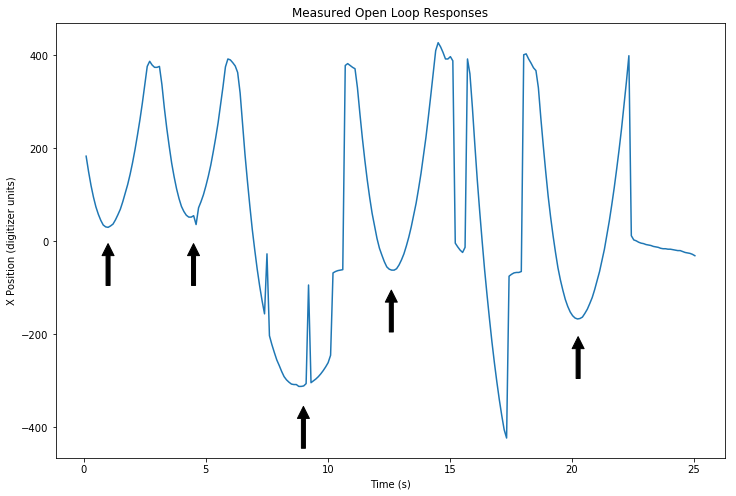

In [9]:
Tstep = 0.1 ### data was collected in 0.1 s increments

with open('stepPlus.csv','r') as fh:
    data_iter = csv.reader(fh, delimiter = ',')
    stepPlus =  np.asmatrix( [data for data in data_iter], dtype =(int) )

plt.figure(figsize=(12,8))

plt.annotate('', xy=(1,0), xytext=(1, -100),
            arrowprops=dict(facecolor='black', shrink=0.05), alpha = 0.5)
plt.annotate('', xy=(4.5,0), xytext=(4.5,-100),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(9,-350), xytext=(9, -450),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(12.6,-100), xytext=(12.6,-200),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(20.25,-200), xytext=(20.25,-300),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Measured Open Loop Responses')
plt.plot(stepPlus[:250,0]/1000,stepPlus[:250,1])
plt.show()

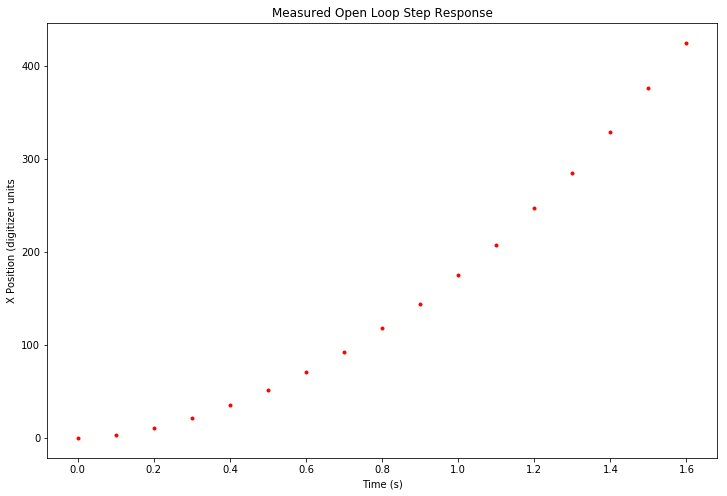

In [10]:
## Pick one step response. Trim and shift appropriately

stepResp = stepPlus[126:143,1] - stepPlus[126,1]  ## measured step response
timeStep = np.arange(stepResp.shape[0]) * Tstep

plt.figure(figsize=(12,8))

plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units')
plt.title('Measured Open Loop Step Response')
plt.plot(timeStep,stepResp, 'r.')
plt.show()

## System dynamics
This system basically boils down to the control input, u, controls the acceleration of the ball. The second term in the B matrix is the scaling factor. Units are digitizer units/s^2 per control unit.

The dynamics of the servo motor were ignored.

In [11]:
# System matrices. N.B. these are continuous time dynamics
A = [[0, 1.],
    [0, 0]]
B = [[0],
    [350.]]
C = [[1., 0]]

## make an open loop system to model the table/ball behavior
syst = control.ss(A, B, C, 0)

## Simulate dynamic system
The B matrix was adjusted to get a close fit to the measured data. In the plot below, you can see the effects of changing the B matrix. The lower value in the B matrix changes the acceleration of the ball. You can fit the longer timepoints better with a slightly lower value or fit the shorter timepoints with a larger value.

Perhaps naively, I went with the medium value. Maybe it would be better to go with the larger B value so that near time predictions will be better and let feedback sort out the rest? Perhaps. Once you start adding more parameters to adjust, the parameter space becomes ever larger and more difficult to navigate.

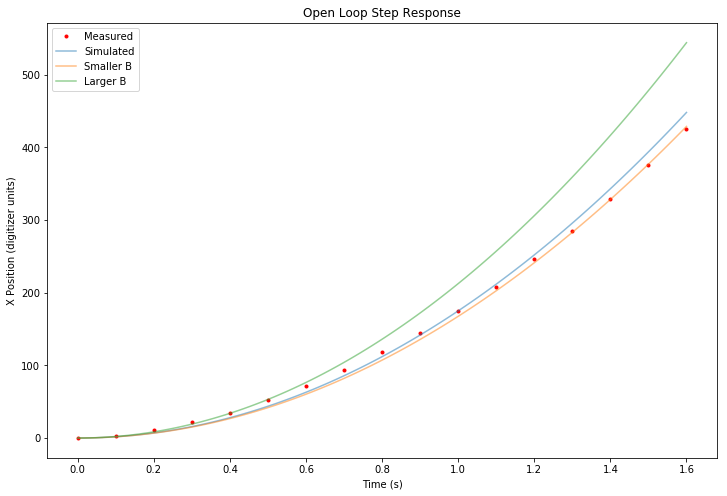

In [26]:
plt.figure(figsize=(12,8))

plt.plot(timeStep,stepResp, 'r.', label='Measured')

T, yout = control.step_response(syst, T = np.linspace(0,1.6, 100),X0=[0,0])
plt.plot(T.T, yout.T, label='Simulated', alpha = 0.5)

sysTemp = control.ss(A, np.matrix([[0],[335]]), C, 0)
T, yout = control.step_response(sysTemp, T = np.linspace(0,1.6, 100),X0=[0,0])
plt.plot(T.T, yout.T, label='Smaller B', alpha = 0.5)

sysTemp = control.ss(A, np.matrix([[0],[425]]), C, 0)
T, yout = control.step_response(sysTemp, T = np.linspace(0,1.6, 100),X0=[0,0])
plt.plot(T.T, yout.T, label='Larger B', alpha = 0.5)



plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Open Loop Step Response')
plt.show(block=False)
plt.show()

## Convert to discrete time system
And simulate again. As expected the discrete time system follows the dynamics of the continuous time system. But nice to confirm.

A = [[1.  0.1]
 [0.  1. ]]

B = [[ 1.75]
 [35.  ]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.1



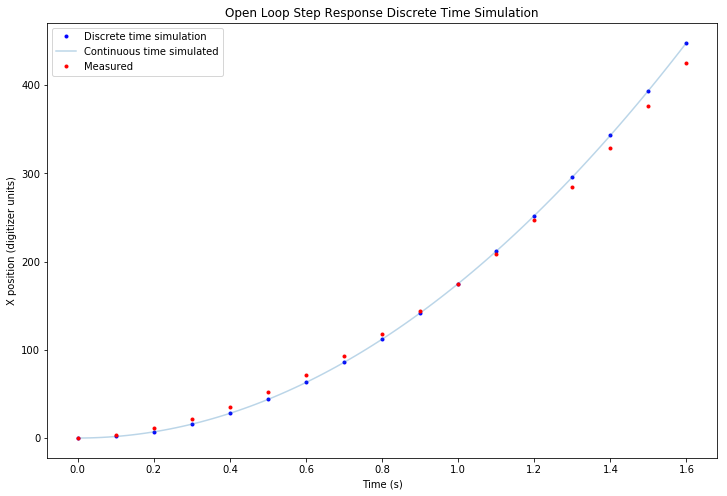

In [15]:
## convert continuous time system (syst) to discrete time system (sysd) with timestep 0.1
sysd = control.c2d(syst, Tstep)


plt.figure(figsize=(12,8))

#### 
Td, youtd = control.step_response(sysd,T=np.arange(17)* Tstep,X0=[0,0])
plt.plot(Td, youtd, 'b.', label='Discrete time simulation')

T, yout = control.step_response(syst, T = np.linspace(0,1.6, 100),X0=[0,0])
plt.plot(T.T, yout.T, label='Continuous time simulated', alpha= 0.3)


plt.plot(timeStep,stepResp, 'r.', label='Measured')
plt.legend(loc="upper left")

plt.xlabel('Time (s)')
plt.ylabel('X position (digitizer units)')
plt.title('Open Loop Step Response Discrete Time Simulation')
print(sysd)
plt.show()

## Confirm that I understand what I think I know

Given an input u, the new state of the system is

x\[k\] = A \* x\[k-1\] + B \* u

Be sure you use the discrete time matrices for this! 

Reassuringly, the system dynamics can be modeled using just matrix math.

A = [[1.  0.1]
 [0.  1. ]]

B = [[ 1.75]
 [35.  ]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.1



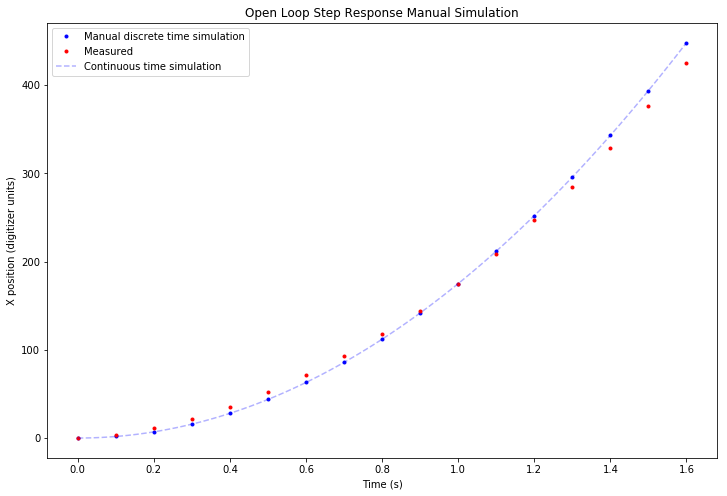

In [25]:
X= np.matrix([[0],[0]])  ## initial value of x
yout = [0]               ### corresponding y value for above

u  = np.matrix([1]) ### unit step input

for i in range(16):         ## should give 0 to 1.6s in 0.1 increments
    X = sysd.A*X + sysd.B * u   ## compute new X with u = np.array([1]), i.e. step
    yout.append( (sysd.C * X )[0,0] )

plt.figure(figsize=(12,8))
plt.plot(np.arange(len(yout))* Tstep,yout, 'b.', label='Manual discrete time simulation')
plt.plot(timeStep,stepResp, 'r.', label='Measured')

T, yout = control.step_response(syst, T = np.linspace(0,1.6, 100),X0=[0,0])
plt.plot(T.T, yout.T, 'b--',alpha = 0.3,label='Continuous time simulation')
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('X position (digitizer units)')
plt.title('Open Loop Step Response Manual Simulation')
print (sysd)
plt.show()

Up next, adding feedback.